In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [14]:
#log-transform
def log_transform(X, columns):
    X = X.copy()
    for col in columns:
        X[col] = np.log(X[col])
    return X

In [15]:
def update_column_names(df):
    df = df.rename(columns={
        'Temperature': 'Temperatura',
        'Humidity': 'Umidade',
        'Wind Speed': 'Velocidade_do_Vento',
        'Cloud Cover': 'Cobertura_de_Nuvens',
        'Pressure': 'Pressao',
        'Location': 'Localizacao',
        'Rain Tomorrow': 'Chovera_Amanha',
        'Precipitation': 'Precipitacao',
        'Date':'Data',
    })
    return df

In [16]:
def get_season(date):
        month = date.month
        day = date.day
        if ((month >= 3 and day >= 20) and (month <= 6 and day < 21)):
                return 'Primavera'
        elif (month >= 6 and ( month <= 9 and day < 23)):
                return 'Verão'
        elif (month >= 9 and (month <= 12 and day < 21)):
                return 'Outono'
        else:
                return 'Inverno'

In [17]:
# Mapeamento completo de cidades para estados
cidade_para_estado = {
    'Los Angeles': 'California', 
    'Chicago': 'Illinois', 
    'Houston': 'Texas',
    'Phoenix': 'Arizona',
    'Philadelphia': 'Pennsylvania',
    'San Antonio': 'Texas', 
    'San Diego': 'California',
    'Dallas': 'Texas',
    'San Jose': 'California', 
    'Austin': 'Texas', 
    'Jacksonville': 'Florida', 
    'Fort Worth': 'Texas',
    'Columbus': 'Ohio', 
    'Indianapolis': 'Indiana', 
    'Charlotte': 'North Carolina', 
    'San Francisco': 'California',
    'Seattle': 'Washington', 
    'Denver': 'Colorado', 
    'New York': 'New York', 
    'Washington D.C.': 
    'District of Columbia'
}
estado_para_regiao = {
    'California': 'Oeste',
    'Illinois': 'Meio-Oeste',
    'Texas': 'Sul',
    'Arizona': 'Oeste',
    'Pennsylvania': 'Nordeste',
    'Florida': 'Sul',
    'Ohio': 'Meio-Oeste',
    'Indiana': 'Meio-Oeste',
    'North Carolina': 'Sul',
    'Washington': 'Oeste',
    'Colorado': 'Oeste',
    'New York': 'Nordeste',
    'District of Columbia': 'Sul'
}
def cidade_para_regiao(cidade: pd.Series) -> str:
    cidade = cidade.title()
    estado = cidade_para_estado.get(cidade)
    return estado_para_regiao.get(estado) if estado else None

In [18]:
numeric_features_pt = ['Temperatura', 'Umidade', 'Velocidade_do_Vento', 'Cobertura_de_Nuvens', 'Pressao']
categorical_features_pt = ['Estacao', 'Regiao']

def pre_processar_df(df, numeric_columns):
    # Transformando os dados numéricos para o log
    df = log_transform(df, numeric_columns)

    # Cria a coluna Estacao
    df['Data'] = pd.to_datetime(df['Data'].sort_values())
    
    df["Estacao"] = df["Data"].apply(get_season)
    
    # Cria a coluna Regiao
    df['Regiao'] = df['Localizacao'].apply(cidade_para_regiao)

    # Remove colunas originais que não serão mais usadas
    df = df.drop(['Data', 'Localizacao'], axis=1)
    return df

# Para usar no pipeline:
preprocess_func = FunctionTransformer(pre_processar_df, kw_args={'numeric_columns': numeric_features_pt}, validate=False)


preprocess_before_transforms_pipeline = Pipeline([
    ('preprocess_func', preprocess_func)
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Preprocessamento
# Cria o pré-processador

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_pt),
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')

preprocessor_without_scaling = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')


# Criando as pipelines
pipeline_sem_scaling = Pipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor_without_scaling),
    ('classifier', LogisticRegression())
])

pipeline = Pipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

search_spaces_logistic = {
    'classifier__C': Real(1e-3, 1.0, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
}

search_spaces_random_forest = {
    'classifier__n_estimators': Integer(50, 100),
    'classifier__max_depth': Integer(2, 10),
    'classifier__bootstrap': Categorical([True, False])
}

search_spaces_decision_tree = {
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__splitter': Categorical(['best', 'random'])
}

search_spaces_knn = {
    'classifier__n_neighbors': Integer(1, 10),
    'classifier__weights': Categorical(['uniform', 'distance']),
    'classifier__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree'])
}

search_spaces_sgd = {
    'classifier__loss': Categorical(['hinge', 'log_loss', 'squared_hinge', 'modified_huber']),
    'classifier__penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform')
}

search_spaces_ridge_classifier = {
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
    'classifier__solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'classifier__max_iter': Integer(100, 1000),
}

In [19]:
# Carregar dados para pipeline e vizualiuzação do durante o notebook
df_to_pipeline_use = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')  # Substitua com o caminho correto
df_to_pipeline_use = update_column_names(df_to_pipeline_use)
print(df_to_pipeline_use.head())

         Data Localizacao  Temperatura    Umidade  Velocidade_do_Vento  \
0  2024-01-01    New York    87.524795  75.655455            28.379506   
1  2024-01-02    New York    83.259325  28.712617            12.436433   
2  2024-01-03    New York    80.943050  64.740043            14.184831   
3  2024-01-04    New York    78.097552  59.738984            19.444029   
4  2024-01-05    New York    37.059963  34.766784             3.689661   

   Precipitacao  Cobertura_de_Nuvens      Pressao  Chovera_Amanha  
0      0.000000            69.617966  1026.030278               0  
1      0.526995            41.606048   995.962065               0  
2      0.916884            77.364763   980.796739               1  
3      0.094134            52.541196   979.012163               0  
4      1.361272            85.584000  1031.790859               0  


Temperatura            408.274078
Umidade                532.045646
Velocidade_do_Vento     75.146854
Precipitacao             0.225466
Cobertura_de_Nuvens    675.089622
Pressao                408.197117
Chovera_Amanha           0.171832
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 73100 non-null  object 
 1   Localizacao          73100 non-null  object 
 2   Temperatura          73100 non-null  float64
 3   Umidade              73100 non-null  float64
 4   Velocidade_do_Vento  73100 non-null  float64
 5   Precipitacao         73100 non-null  float64
 6   Cobertura_de_Nuvens  73100 non-null  float64
 7   Pressao              73100 non-null  float64
 8   Chovera_Amanha       73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB
None
        Temperatura   

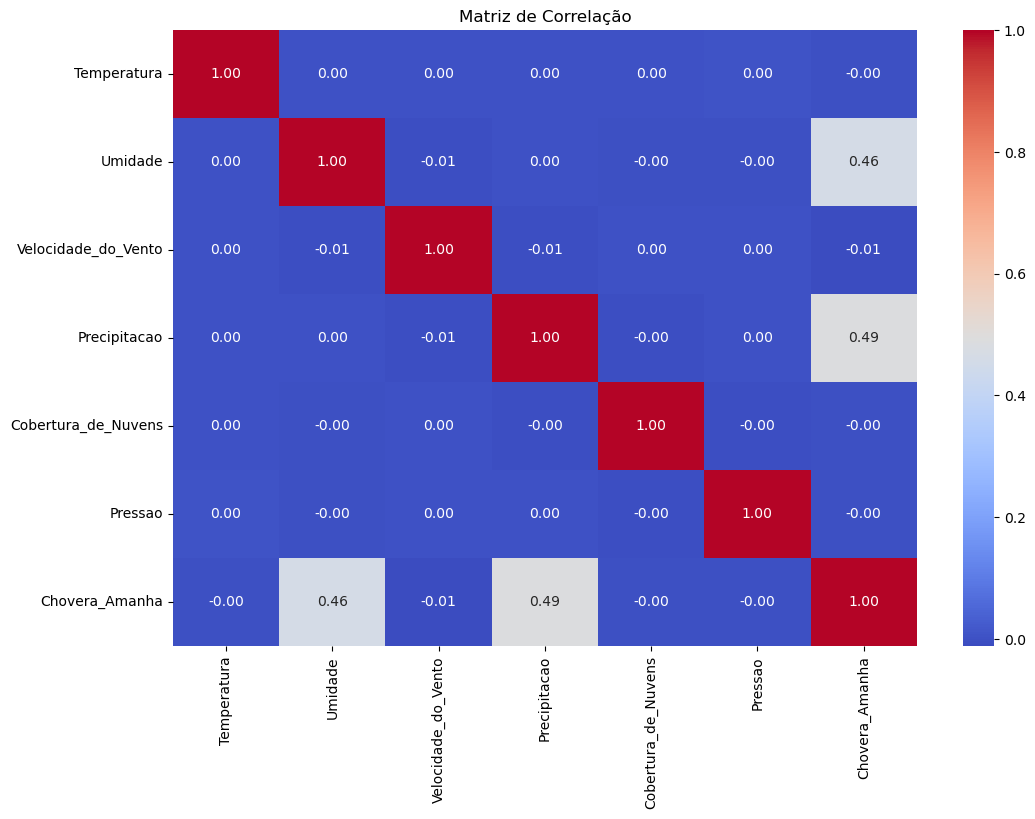

In [23]:
print(df_to_pipeline_use.var(numeric_only=True))
print(df_to_pipeline_use.info())
print(df_to_pipeline_use.describe())
print(df_to_pipeline_use.isnull().sum())

plt.figure(figsize=(12, 8))
sns.heatmap(df_to_pipeline_use.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size":10})
plt.title('Matriz de Correlação')
plt.show()


In [24]:
def avaliar_modelos_pipeline(X_train, X_test, y_train, y_test, search_spaces, modelo = LogisticRegression, scaled=False):
    pipeline_a_ser_usada = pipeline_sem_scaling if not scaled else pipeline
    
    pipeline_a_ser_usada.set_params(classifier=modelo)
    bayes_search = BayesSearchCV(
        estimator=pipeline_a_ser_usada,
        search_spaces=search_spaces,
        n_iter=3,  # Ajuste conforme o tempo disponível
        cv=3,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    print(f"Treinando com a Pipeline: {pipeline_a_ser_usada}")
    # Treina o BayesSearchCV
    bayes_search.fit(X_train, y_train)
    print(f"Melhor pontuação: {bayes_search.best_score_}")
    print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")

    # Pega o melhor pipeline encontrado
    melhor_pipeline = bayes_search.best_estimator_
    
    # Faz predições com o melhor pipeline
    y_pred_train = cross_val_predict(melhor_pipeline, X_train, y_train, cv=3, n_jobs=-1)
    
    melhor_pipeline.fit(X_train, y_train)
    y_pred_test = melhor_pipeline.predict(X_test)

    return {
        'Modelo': type(melhor_pipeline.named_steps['classifier']).__name__ + (' (Escalado)' if scaled else ''),
        'Melhor Modelo' : melhor_pipeline,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision Train': precision_score(y_train, y_pred_train),
        'Precision Test': precision_score(y_test, y_pred_test),
        'Recall Train': recall_score(y_train, y_pred_train),
        'Recall Test': recall_score(y_test, y_pred_test),
        'F1 Score Train': f1_score(y_train, y_pred_train),
        'F1 Score Test': f1_score(y_test, y_pred_test),
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'Melhores Hiperparâmetros': bayes_search.best_params_
    }


In [25]:
X_pipeline = df_to_pipeline_use.drop('Chovera_Amanha', axis=1)
y_pipeline = df_to_pipeline_use['Chovera_Amanha']
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipeline, y_pipeline, test_size=0.2, random_state=42, shuffle=False)

dict_modelos_pipeline = {
    'Logistic Regression': {
        'search_spaces': search_spaces_logistic,
        'modelo': LogisticRegression()
    },
    'Random Forest': {
        'search_spaces': search_spaces_random_forest,
        'modelo': RandomForestClassifier()
    },
    'Decision Tree': {
        'search_spaces': search_spaces_decision_tree,
        'modelo': DecisionTreeClassifier()
    },
    'KNN': {
        'search_spaces': search_spaces_knn,
        'modelo': KNeighborsClassifier()
    },
    'SGD Classifier': {
        'search_spaces': search_spaces_sgd,
        'modelo': SGDClassifier()
    },
    'Ridge Classifier': {
        'search_spaces': search_spaces_ridge_classifier,
        'modelo': RidgeClassifier()
    }
}

resultados_pipeline = []
for info in dict_modelos_pipeline.values():
    resultados_pipeline.extend(
        (
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=False,
            ),
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=True,
            ),
        )
    )



Treinando com a Pipeline: Pipeline(steps=[('preprocess_func',
                 FunctionTransformer(func=<function pre_processar_df at 0x000001E49843EAC0>,
                                     kw_args={'numeric_columns': ['Temperatura',
                                                                  'Umidade',
                                                                  'Velocidade_do_Vento',
                                                                  'Cobertura_de_Nuvens',
                                                                  'Pressao']})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=

In [11]:
df_resultados = pd.DataFrame(resultados_pipeline)
df_resultados.head()


,Modelo,Melhor Modelo,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Score Train,F1 Score Test,y_pred_train,y_pred_test,Melhores Hiperparâmetros
0,LogisticRegression,(FunctionTransformer(func=<function pre_proces...,0.918246,0.915937,0.862696,0.855520,0.747826,0.745668,0.801164,0.796826,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...","{'classifier__C': 0.3252108800594495, 'classif..."
1,LogisticRegression (Escalado),(FunctionTransformer(func=<function pre_proces...,0.918211,0.916416,0.859899,0.855124,0.751009,0.748762,0.801774,0.798416,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...","{'classifier__C': 0.3252108800594495, 'classif..."
2,RandomForestClassifier,(FunctionTransformer(func=<function pre_proces...,0.999949,1.000000,1.000000,1.000000,0.999767,1.000000,0.999884,1.000000,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...","{'classifier__bootstrap': True, 'classifier__m..."
3,RandomForestClassifier (Escalado),(FunctionTransformer(func=<function pre_proces...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...","{'classifier__bootstrap': False, 'classifier__..."
4,DecisionTreeClassifier,(FunctionTransformer(func=<function pre_proces...,0.998871,0.998632,0.997438,0.997830,0.997438,0.995978,0.997438,0.996903,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...","{'classifier__criterion': 'gini', 'classifier_..."


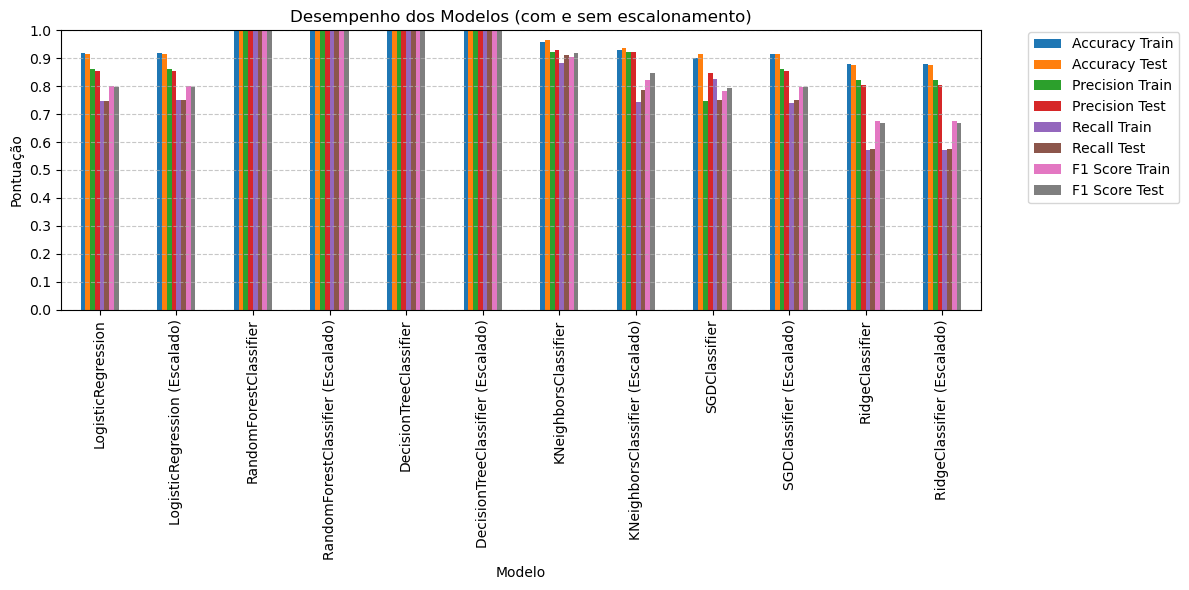

In [12]:
import matplotlib.ticker as ticker  # Importe para controlar as marcações do eixo

fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[[
    'Accuracy Train', 
    'Accuracy Test',
    'Precision Train',
    'Precision Test',
    'Recall Train', 
    'Recall Test',
    'F1 Score Train', 
    'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)

# Configurar marcações do eixo Y (passos de 0.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Define intervalos de 0.1
ax.set_ylim(0, 1)  # Garante que o eixo Y vá de 0 a 1 (ajuste se necessário)

# Adicionar grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid horizontal tracejado

# Ajustar legenda fora do gráfico
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.1
)

plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
